# 05. Semi-supervised AQI Classification — Co-Training

- Mục tiêu: chạy co-training theo **2 views** (mặc định: view theo pattern thời gian/station và phần còn lại).
- Output: metrics JSON + sample predictions + sample alerts.
- Mini project: tự thiết kế VIEW1_COLS / VIEW2_COLS và chứng minh view tốt.

In [1]:
SEMI_DATASET_PATH = "data/processed/02_dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

TAU = 0.90
MAX_ITER = 10
MAX_NEW_PER_ITER = 500
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

METRICS_PATH = "data/processed/05_metrics_co_training.json"
PRED_SAMPLE_PATH = "data/processed/05_predictions_co_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/processed/05_alerts_co_training_sample.csv"
ALERT_FROM_CLASS = "Unhealthy"

# Optionally set explicit views (list of column names), otherwise None -> auto split
VIEW1_COLS = None
VIEW2_COLS = None

In [2]:
# Parameters
SEMI_DATASET_PATH = "data/processed/02_dataset_for_semi.parquet"
CUTOFF = "2017-01-01"
TAU = 0.8
MAX_ITER = 2
MAX_NEW_PER_ITER = 100
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.2
RANDOM_STATE = 42
METRICS_PATH = "data/processed/11_16_metrics_co_training.json"
PRED_SAMPLE_PATH = None
ALERTS_SAMPLE_PATH = None
ALERT_FROM_CLASS = "Unhealthy"
VIEW1_COLS = ["No", "year", "hour", "PM10", "SO2", "NO2", "CO", "O3", "TEMP", "WSPM", "hour_sin", "hour_cos", "dow", "is_weekend", "PM10_lag1", "SO2_lag1", "CO_lag1", "O3_lag1", "TEMP_lag1", "WSPM_lag1", "PM10_lag3", "SO2_lag3", "NO2_lag3", "CO_lag3", "O3_lag3", "WSPM_lag3", "SO2_lag24", "NO2_lag24", "O3_lag24", "TEMP_lag24", "RAIN_lag24", "wd", "station"]
VIEW2_COLS = ["month", "day", "PRES", "DEWP", "RAIN", "NO2_lag1", "PRES_lag1", "DEWP_lag1", "RAIN_lag1", "TEMP_lag3", "PRES_lag3", "DEWP_lag3", "RAIN_lag3", "PM10_lag24", "CO_lag24", "PRES_lag24", "DEWP_lag24", "WSPM_lag24"]


,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.704442,0.640478,383962,100,0.8
1,2,0.707976,0.642996,383862,100,0.8


Test accuracy: 0.5697918541179293
Test f1_macro: 0.453746008487068


{'view1_cols': ['No',
  'year',
  'hour',
  'PM10',
  'SO2',
  'NO2',
  'CO',
  'O3',
  'TEMP',
  'WSPM',
  'hour_sin',
  'hour_cos',
  'dow',
  'is_weekend',
  'PM10_lag1',
  'SO2_lag1',
  'CO_lag1',
  'O3_lag1',
  'TEMP_lag1',
  'WSPM_lag1',
  'PM10_lag3',
  'SO2_lag3',
  'NO2_lag3',
  'CO_lag3',
  'O3_lag3',
  'WSPM_lag3',
  'SO2_lag24',
  'NO2_lag24',
  'O3_lag24',
  'TEMP_lag24',
  'RAIN_lag24',
  'wd',
  'station'],
 'view2_cols': ['month',
  'day',
  'PRES',
  'DEWP',
  'RAIN',
  'NO2_lag1',
  'PRES_lag1',
  'DEWP_lag1',
  'RAIN_lag1',
  'TEMP_lag3',
  'PRES_lag3',
  'DEWP_lag3',
  'RAIN_lag3',
  'PM10_lag24',
  'CO_lag24',
  'PRES_lag24',
  'DEWP_lag24',
  'WSPM_lag24'],
 'view1_numeric_cols': ['No',
  'year',
  'hour',
  'PM10',
  'SO2',
  'NO2',
  'CO',
  'O3',
  'TEMP',
  'WSPM',
  'hour_sin',
  'hour_cos',
  'dow',
  'is_weekend',
  'PM10_lag1',
  'SO2_lag1',
  'CO_lag1',
  'O3_lag1',
  'TEMP_lag1',
  'WSPM_lag1',
  'PM10_lag3',
  'SO2_lag3',
  'NO2_lag3',
  'CO_lag3',
  'O

Figure saved to: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\05_co_training_dynamics.png


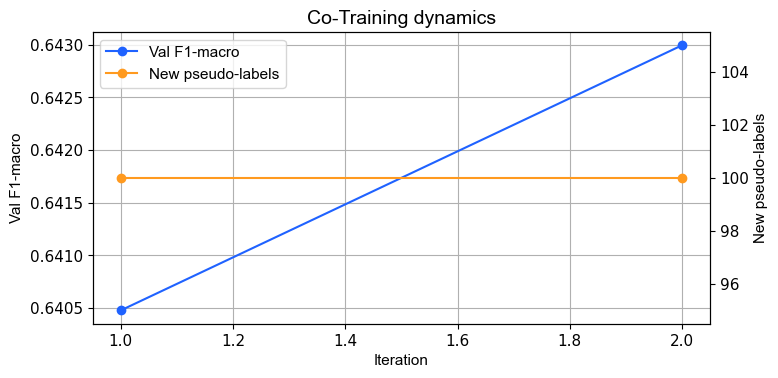

Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\11_16_metrics_co_training.json


In [3]:
from pathlib import Path
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt

# Find project root and add to path BEFORE importing from src
PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.semi_supervised_library import (
    SemiDataConfig, CoTrainingConfig, run_co_training, add_alert_columns
)

df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=int(RANDOM_STATE))
ct_cfg = CoTrainingConfig(
    tau=float(TAU),
    max_iter=int(MAX_ITER),
    max_new_per_iter=int(MAX_NEW_PER_ITER),
    min_new_per_iter=int(MIN_NEW_PER_ITER),
    val_frac=float(VAL_FRAC),
)

out = run_co_training(df, data_cfg, ct_cfg, view1_cols=VIEW1_COLS, view2_cols=VIEW2_COLS)
history = pd.DataFrame(out["history"])
pred_df = out["pred_df"]
test_metrics = out["test_metrics"]

display(history)
print("Test accuracy:", test_metrics["accuracy"])
print("Test f1_macro:", test_metrics["f1_macro"])
display(out["model_info"])

# Plot dynamics
fig, ax1 = plt.subplots(figsize=(8, 4))
line1 = ax1.plot(history["iter"], history["val_f1_macro"], marker="o", color="#1F62FF", label="Val F1-macro")
ax1.set_xlabel("Iteration", fontsize=11, fontfamily='Arial')
ax1.set_ylabel("Val F1-macro", fontsize=11, fontfamily='Arial')
ax1.tick_params(axis='both', labelsize=11)
ax1.grid(True)

ax2 = ax1.twinx()
line2 = ax2.plot(history["iter"], history["new_pseudo"], marker="o", color="#FF9A1F", label="New pseudo-labels")
ax2.set_ylabel("New pseudo-labels", fontsize=11, fontfamily='Arial')
ax2.tick_params(axis='y', labelsize=11)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best', prop={'family': 'Arial', 'size': 11})

plt.title("Co-Training dynamics", fontsize=14, fontfamily='Arial')
plt.tight_layout(pad=1.5)

# Save figure based on instructions
images_dir = PROJECT_ROOT / "images"
images_dir.mkdir(parents=True, exist_ok=True)
fig_path = images_dir / "05_co_training_dynamics.png"
fig.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {fig_path}")

plt.show()

# Save artifacts
if METRICS_PATH:
    metrics_path = (PROJECT_ROOT / METRICS_PATH).resolve()
    metrics_path.parent.mkdir(parents=True, exist_ok=True)
    
    payload = {
        "method": "co_training",
        "data_cfg": data_cfg.__dict__,
        "ct_cfg": ct_cfg.__dict__,
        "history": out["history"],
        "test_metrics": test_metrics,
        "model_info": out["model_info"],
    }
    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)
    print("Saved:", metrics_path)

if PRED_SAMPLE_PATH:
    pred_path = (PROJECT_ROOT / PRED_SAMPLE_PATH).resolve()
    pred_path.parent.mkdir(parents=True, exist_ok=True)
    pred_df.head(5000).to_csv(pred_path, index=False)
    print("Saved:", pred_path)

if ALERTS_SAMPLE_PATH:
    alerts_path = (PROJECT_ROOT / ALERTS_SAMPLE_PATH).resolve()
    alerts_path.parent.mkdir(parents=True, exist_ok=True)
    alerts = add_alert_columns(pred_df, pred_col="y_pred", severe_from=ALERT_FROM_CLASS)
    alerts.head(5000).to_csv(alerts_path, index=False)
    print("Saved:", alerts_path)